# Automated Hyperparameter Selection 

This tutorial demonstrates how to automatically select optimal Gaussian Process hyperparameters for your surrogate model by testing multiple configurations and choosing the one with the best test set performance.

## Why This Matters

GP surrogate model performance is highly sensitive to:
- **Kernel choice** (ExpSquared, Matern32, Matern52, etc.)
- **Data scaling** (no scaling, MinMax, StandardScaler)
- **Other hyperparameters** (white noise, amplitude, length scales)

Rather than manually tuning these, we can systematically test combinations and select the best configuration based on test set mean squared error (MSE).

## Step 1: Import Required Libraries

Import `alabi` and its submodules along with standard scientific computing libraries.

In [1]:
import sys 
sys.path.append("/Users/m1/research/alabi")
import alabi
import alabi.utility as ut
import alabi.metrics as metrics
import alabi.benchmarks as bm
import alabi.visualization as vis
from alabi.core import SurrogateModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from sklearn import preprocessing
from itertools import product

## Step 2: Define Problem and Base Configuration

Set up the benchmark problem (eggbox function) and define a base configuration for GP hyperparameters. These settings will be partially overridden when we test different combinations.

**Key parameters:**
- `ninit`: Number of initial training points
- `niter`: Number of active learning iterations
- `ncore`: Number of CPU cores for parallel evaluation (use 1 if experiencing multiprocessing issues)
- `white_noise`: Log-scale white noise parameter (increase if you see positive definiteness errors)

In [2]:
ninit = 50
niter = 100
basedir = "demo"
kernel = "ExpSquaredKernel"
benchmark = "rosenbrock"
savedir = f"{basedir}/{benchmark}/{kernel}/{ninit}_{niter}"

gp_kwargs = {"kernel": kernel, 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "hyperopt_method": "cv",
             "cv_folds": 8,
             "gp_amp_rng": [-1,1],
             "gp_scale_rng": [-2,2],
             "theta_scaler": alabi.no_scaler,
             "y_scaler": alabi.no_scaler}
    
sm = SurrogateModel(lnlike_fn=bm.eggbox["fn"], 
                    bounds=bm.eggbox["bounds"], 
                    savedir=savedir,
                    ncore=8, 
                    verbose=True)

sm.init_samples(ntrain=ninit, ntest=1000, sampler="sobol")

100%|██████████| 1000/1000 [00:00<00:00, 41473.56it/s]


## Step 3: Create Hyperparameter Grid

Generate all combinations of the hyperparameters we want to test:
- **Kernels**: Different covariance functions capture different smoothness assumptions
- **Theta scaler**: How to scale input parameters
- **Y scaler**: How to scale output values

The `dict_to_combinations` function creates a Cartesian product of all options.

In [3]:
def dict_to_combinations(options_dict):
    keys = options_dict.keys()
    values = options_dict.values()
    return [dict(zip(keys, combo)) for combo in product(*values)]

def combinations_to_dict(combinations):
    result = {key: [] for key in combinations[0].keys()}
    for combo in combinations:
        for key, value in combo.items():
            result[key].append(value)
    return result

gp_kwarg_options = {"kernel": ["ExpSquaredKernel", "Matern32Kernel", "Matern52Kernel"],
                    "theta_scaler": [ut.no_scaler, preprocessing.MinMaxScaler(), preprocessing.StandardScaler()],
                    "y_scaler": [ut.no_scaler, preprocessing.MinMaxScaler(), preprocessing.StandardScaler()]}

variable_settings = dict_to_combinations(gp_kwarg_options)
print(len(variable_settings), "combinations to test")

# get a list of dictionaries with all combinations of settings, where each dictionary is a copy of the original gp_kwargs with the variable settings updated
setting_combos = []
for settings in variable_settings:
    new_settings = gp_kwargs.copy()
    for key in settings.keys():
        new_settings[key] = settings[key]
    setting_combos.append(new_settings)

27 combinations to test


## Step 4: Test All Hyperparameter Combinations

Loop through all combinations and fit a GP for each. The `init_gp` method returns the test set MSE, which we use to evaluate performance.

**Note:** This can take several minutes depending on the number of combinations and problem dimensionality. Use `try/except` to handle configurations that fail to converge.

In [4]:
for ii in range(len(setting_combos)):
    try:
        test_mse = sm.init_gp(**setting_combos[ii], overwrite=True)
    except:
        test_mse = np.nan
    setting_combos[ii]["test_mse"] = test_mse

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 1026.44candidate/s]

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 948.11candidate/s]

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 935.66candidate/s]

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 969.58candidate/s]

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 908.24candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 978.82candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 1019.16candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 967.45candidate/s]

Initialized GP with squared exponential kernel.


Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 934.05candidate/s]

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 1024.88candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 903.71candidate/s]

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 935.87candidate/s]

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 1061.26candidate/s]

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 957.41candidate/s]

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 944.60candidate/s]

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 1044.52candidate/s]

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 961.43candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 963.72candidate/s]

Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 1037.77candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 909.88candidate/s]

Initialized GP with Matérn-5/2 kernel.


Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 959.25candidate/s]

Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 1068.61candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 963.29candidate/s]

Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 918.71candidate/s]

Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 1074.90candidate/s]

Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 982.97candidate/s]

Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 971.67candidate/s]


## Step 5: Analyze Results

Convert results to a pandas DataFrame and inspect the top-performing configurations. Lower test MSE indicates better generalization performance.

In [5]:
results = pd.DataFrame(data=combinations_to_dict(setting_combos))
results.sort_values("test_mse").head(10)

,kernel,fit_amp,fit_mean,fit_white_noise,white_noise,gp_opt_method,hyperopt_method,cv_folds,gp_amp_rng,gp_scale_rng,theta_scaler,y_scaler,test_mse
16,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),minmax_scaler(),2647.813534
17,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),StandardScaler(),2972.363325
26,Matern52Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),StandardScaler(),3057.813987
14,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",minmax_scaler(),StandardScaler(),3136.230493
15,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),no_scaler(func=<function no_scale at 0x124f6d2...,3237.019364
24,Matern52Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),no_scaler(func=<function no_scale at 0x124f6d2...,3280.164115
13,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",minmax_scaler(),minmax_scaler(),3363.125716
11,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",no_scaler(func=<function no_scale at 0x124f6d2...,StandardScaler(),3371.818740
12,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",minmax_scaler(),no_scaler(func=<function no_scale at 0x124f6d2...,3458.169750
2,ExpSquaredKernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",no_scaler(func=<function no_scale at 0x124f6d2...,StandardScaler(),3519.166898


## Step 6: Extract Best Configuration

Identify the hyperparameter configuration with the lowest test MSE. This will be used for active learning.

In [6]:
best_gp_results = results[results["test_mse"] == results["test_mse"].min()]
best_gp_results

,kernel,fit_amp,fit_mean,fit_white_noise,white_noise,gp_opt_method,hyperopt_method,cv_folds,gp_amp_rng,gp_scale_rng,theta_scaler,y_scaler,test_mse
16,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),minmax_scaler(),2647.813534


## Step 7: Run Active Learning

Use the optimal GP configuration for active learning. The BAPE (Bayesian Active Posterior Estimation) algorithm iteratively selects new training points to improve the surrogate model.

**Key active learning parameters:**
- `algorithm`: Acquisition function ("bape", "agp", or "jones")
- `gp_opt_freq`: How often to reoptimize GP hyperparameters during training
- `obj_opt_method`: Optimization method for acquisition function
- `nopt`: Number of optimization restarts for acquisition function

In [9]:
best_gp_kwargs = best_gp_results[gp_kwargs.keys()].to_dict(orient="records")[0]

al_kwargs = {"algorithm": "bape", 
             "gp_opt_freq": 20, 
             "obj_opt_method": "nelder-mead", 
             "nopt": 6}

sm.init_gp(**best_gp_kwargs, overwrite=True)
sm.active_train(niter=200, **al_kwargs)

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 831.06candidate/s]


Running 200 active learning iterations using bape...


  8%|▊         | 16/200 [00:00<00:04, 42.65it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 13%|█▎        | 26/200 [00:00<00:05, 29.63it/s]

Train MSE: 6.958237388561455e-07
Test MSE: 1986.0560682479377


 18%|█▊        | 36/200 [00:01<00:04, 36.21it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 23%|██▎       | 46/200 [00:01<00:05, 26.42it/s]

Train MSE: 6.544658124625106e-07
Test MSE: 1883.5143303035568


 28%|██▊       | 56/200 [00:01<00:04, 32.99it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 32%|███▎      | 65/200 [00:02<00:05, 25.15it/s]

Train MSE: 1.4052526397587378e-06
Test MSE: 1783.7549644811004


 38%|███▊      | 75/200 [00:02<00:03, 31.67it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 42%|████▎     | 85/200 [00:03<00:04, 24.55it/s]

Train MSE: 1.0784851709731925e-06
Test MSE: 1331.7794225058467


 50%|████▉     | 99/200 [00:03<00:02, 33.68it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 54%|█████▍    | 108/200 [00:03<00:03, 24.35it/s]

Train MSE: 3.9558561093120164e-05
Test MSE: 1107.4925944720299


 59%|█████▉    | 118/200 [00:04<00:02, 31.85it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 64%|██████▎   | 127/200 [00:04<00:03, 23.35it/s]

Train MSE: 0.012676157255503093
Test MSE: 947.6210955282729


 68%|██████▊   | 137/200 [00:04<00:02, 30.61it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 73%|███████▎  | 146/200 [00:05<00:02, 22.46it/s]

Train MSE: 1.1055398089607343e-05
Test MSE: 860.45992976821


 80%|███████▉  | 159/200 [00:05<00:01, 30.90it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 82%|████████▏ | 163/200 [00:06<00:02, 17.50it/s]

Train MSE: 1.8978104730017837e-05
Test MSE: 774.0483198850717


 88%|████████▊ | 176/200 [00:06<00:00, 26.84it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 92%|█████████▏| 184/200 [00:07<00:00, 18.76it/s]

Train MSE: 0.0005468073975669188
Test MSE: 729.1889453099124


 98%|█████████▊| 196/200 [00:07<00:00, 27.41it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


100%|██████████| 200/200 [00:08<00:00, 24.33it/s]


Train MSE: 5.5923109676687816e-05
Test MSE: 701.243545289366
Caching model to demo/rosenbrock/ExpSquaredKernel/50_100/surrogate_model...


## Step 8: Visualize Training Progress

Plot the test set MSE over active learning iterations. A decreasing trend indicates the surrogate model is improving. 

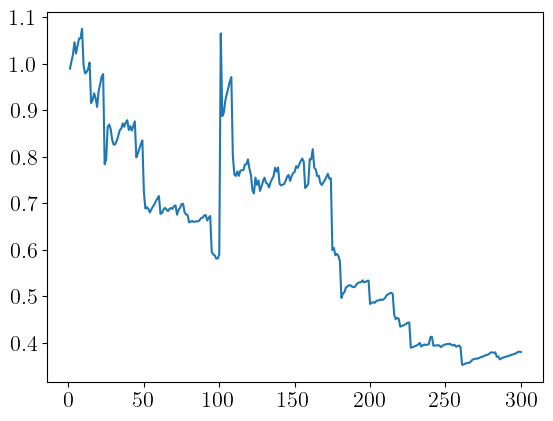

In [14]:
plt.plot(sm.training_results["iteration"], sm.training_results["test_scaled_mse"])
# plt.yscale("log")
plt.show()

## Next Steps

Now that you have an optimized surrogate model, you can:

1. **Run posterior sampling** with `sm.run_emcee()` or `sm.run_dynesty()`
2. **Visualize the surrogate** using `alabi.visualization` tools
3. **Test on new problems** by changing the benchmark function
4. **Expand the hyperparameter grid** to include more options like:
   - Different `white_noise` values
   - Different `cv_folds` settings
   - Different data scaling functions for `theta_scaler` or `y_scaler`